<a href="https://colab.research.google.com/github/AdrianSKazi/BTC-USD-Prediction-by-LSTM/blob/main/BTC_USD_Price_Prediction_by_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 5)

## Import

In [ ]:
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df = df[['Close']]
df.head()

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


## Viz

Text(0.5, 1.0, 'BTC Closing Price')

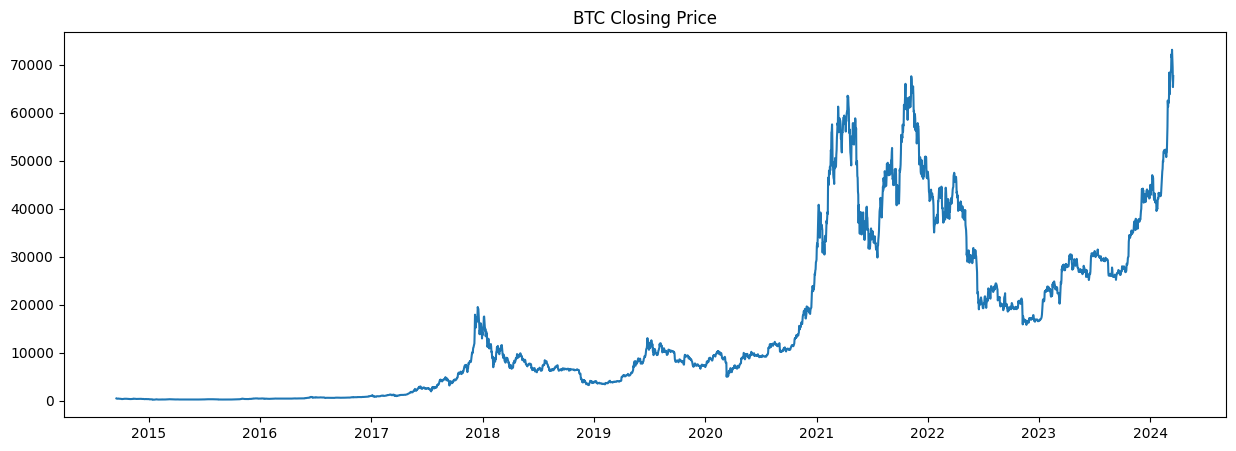

In [ ]:
plt.plot(df['Close'])
plt.title('BTC Closing Price')

# LSTM Model

## Model 1

### Train-Val-Test split

In [ ]:
# Assuming df is your DataFrame with Date as index and Price as a column

# Define the train-validation-test split ratios
train_val_ratio = 0.8
train_ratio = 0.8

# Split the data into train and test sets
train_val_idx = int(len(df) * train_val_ratio)
train_df = df.iloc[:train_val_idx]
test_df = df.iloc[train_val_idx:]

# Further split the train and validation sets
train_idx = int(len(train_df) * train_ratio)
train_df, val_df = train_df.iloc[:train_idx], train_df.iloc[train_idx:]

print('total df shape:',df.shape)
print('--------------------')
print('scaled_train_data shape:',train_df.shape)
print('scaled_val_data shape:',val_df.shape)
print('scaled_test_data shape:',test_df.shape)

total df shape: (3470, 1)
--------------------
scaled_train_data shape: (2220, 1)
scaled_val_data shape: (556, 1)
scaled_test_data shape: (694, 1)


So, to make it clear. I took full dataset named df. Then I splitted df into:

* train_val set (80% of df)
* test set (20% of df)

Then train_val df I splitted into:

* train set (80% of train_val, 80% * 80% = 64% of df)
* val (20% of train_val and 20% * 80% = 16% of df)

### Plot Data

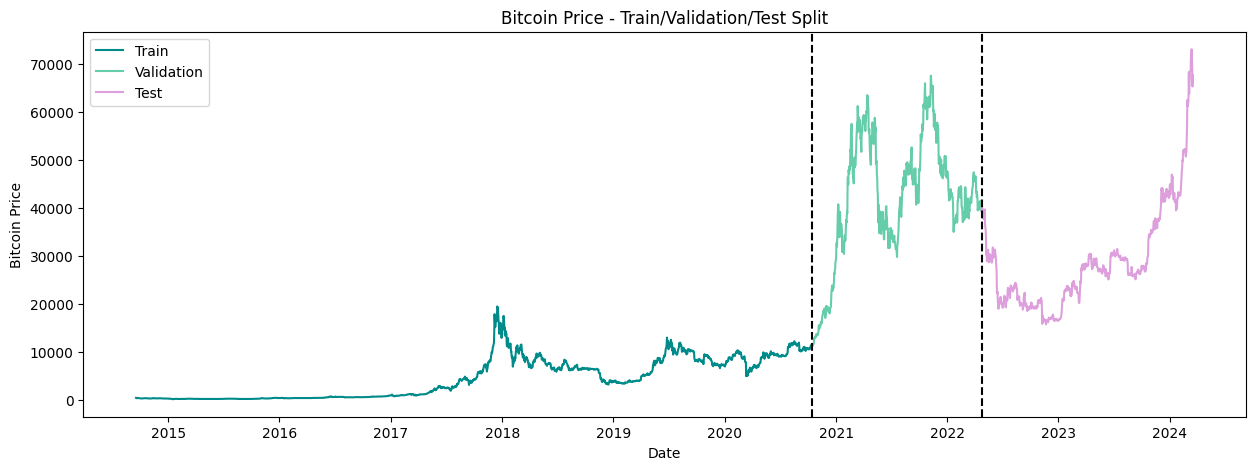

In [ ]:
plt.plot(train_df, color='darkcyan', label='Train')

plt.plot(val_df, color='mediumaquamarine', label='Validation')

plt.plot(test_df, color='plum', label='Test')

plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price - Train/Validation/Test Split')
plt.legend()

# Add vertical lines
plt.axvline(x=val_df.index[0], color='black', linestyle='--', label='Train/Validation Split')
plt.axvline(x=test_df.index[0], color='black', linestyle='--', label='Validation/Test Split')

plt.show()

Model will be trained on Train data and Validation data, meaning model will try to minimize loss between predicted data from Train data and Validation data. This of course will cause that model will already see Validation data and later on we want to test it on data that have never been seen so we will be able to check actual loss, not only validation loss, for that reason we have Test data that will be used after training.

### Preprocessing

In [ ]:
import numpy as np

def create_dataset(dataframe, first_date, last_date, n=3):

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    dataframe = pd.DataFrame(dataframe)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Normalize the data
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_df[['Close']])
scaled_val_data = scaler.transform(val_df[['Close']])
scaled_test_data = scaler.transform(test_df[['Close']])

# Define window size (number of time steps to look back)
window_size = 30

# Function to create windowed dataset, where we take e.g. 30 time steps to predict 31th we roll through the whole dataset by 1 timestep
def create_dataset(data, window_size):
   X, y = [], []
   for i in range(len(data) - window_size):
      X.append(data[i:(i + window_size)])
      y.append(data[i + window_size])

   return np.array(X), np.array(y)

# Create windowed datasets for train, validation, and test sets
X_train, y_train = create_dataset(scaled_train_data, window_size)
X_val, y_val = create_dataset(scaled_val_data, window_size)
X_test, y_test = create_dataset(scaled_test_data, window_size)

### Architecture

In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(units=10, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    LSTM(units=20, return_sequences=True),
    Dropout(0.1),
    LSTM(units=30),
    Dropout(0.2),
    Dense(units=1)
])

### Compile

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val), verbose=2)

Epoch 1/30
35/35 - 15s - loss: 0.0242 - val_loss: 0.8968 - 15s/epoch - 428ms/step
Epoch 2/30
35/35 - 1s - loss: 0.0053 - val_loss: 1.2994 - 1s/epoch - 43ms/step
Epoch 3/30
35/35 - 1s - loss: 0.0037 - val_loss: 1.3395 - 1s/epoch - 39ms/step
Epoch 4/30
35/35 - 1s - loss: 0.0038 - val_loss: 1.4375 - 1s/epoch - 39ms/step
Epoch 5/30
35/35 - 1s - loss: 0.0034 - val_loss: 1.5078 - 1s/epoch - 38ms/step
Epoch 6/30
35/35 - 1s - loss: 0.0035 - val_loss: 1.5531 - 1s/epoch - 39ms/step
Epoch 7/30
35/35 - 1s - loss: 0.0033 - val_loss: 1.4297 - 1s/epoch - 41ms/step
Epoch 8/30
35/35 - 1s - loss: 0.0028 - val_loss: 1.4186 - 1s/epoch - 38ms/step
Epoch 9/30
35/35 - 2s - loss: 0.0027 - val_loss: 1.3135 - 2s/epoch - 58ms/step
Epoch 10/30
35/35 - 2s - loss: 0.0025 - val_loss: 1.1996 - 2s/epoch - 49ms/step
Epoch 11/30
35/35 - 1s - loss: 0.0027 - val_loss: 1.2411 - 1s/epoch - 38ms/step
Epoch 12/30
35/35 - 1s - loss: 0.0025 - val_loss: 1.2275 - 1s/epoch - 37ms/step
Epoch 13/30
35/35 - 1s - loss: 0.0022 - val_lo

### Validation Loss

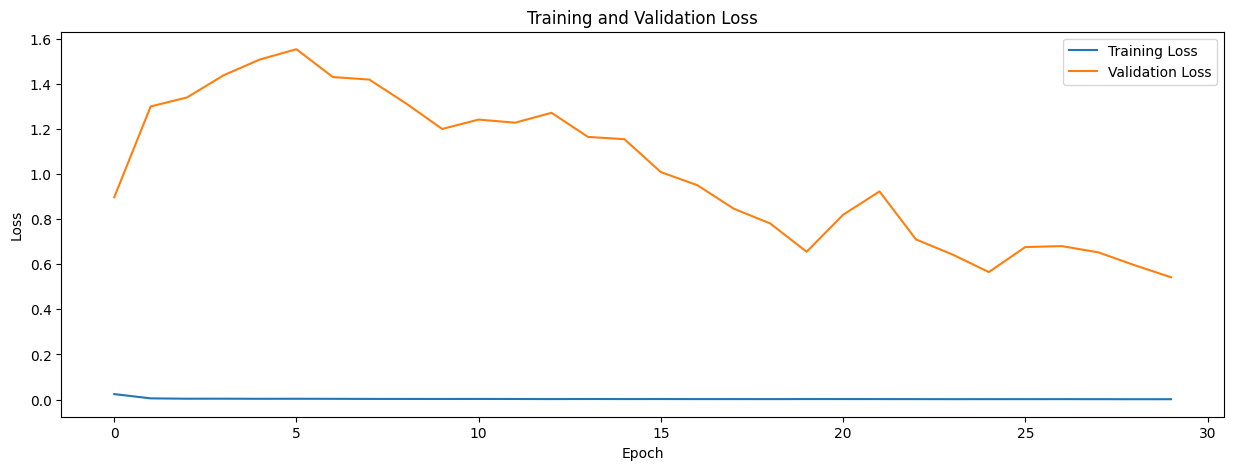

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Validation Dates Range Predictions

In [ ]:
def prediction(last_30_days, model, scaler, first_pred_date, predict_n_days = 30):
  predictions_future = []

  for _ in range(predict_n_days):
      # Use the trained model to make a prediction
      predicted_price = model.predict(last_30_days)

      # Append predictions_future list with predicted price
      predictions_future.append(predicted_price)

      # Remove first day in last 30 days
      last_30_days = np.delete(last_30_days, 0, axis = 1)

      # Append predicted_price at the end of last 30 days, so for next prediction last 30 days will exclude 1 day from beggining of previous window and include predicted price from last window
      last_30_days = np.append(last_30_days, [predicted_price], axis = 1)

 # Inverse transform the predictions and actual values
  predictions_future = [pred[0] for pred in predictions_future]
  predictions_future = scaler.inverse_transform(predictions_future)

  # Create a list of 30 dates starting from the starting date
  date_list = [first_pred_date + pd.Timedelta(days=i) for i in range(predict_n_days)]

  # Create a dataframe for future dates and with future price predictions
  predictions_future_df = pd.DataFrame(index=date_list, columns=["Close"], data=predictions_future)

  return predictions_future_df

In [ ]:
predictions_val_df = prediction(last_30_days=X_train[-1:],
                                model=model,
                                scaler=scaler,
                                first_pred_date=train_df.index[-1]+pd.Timedelta(days=1),
                                predict_n_days = len(val_df))

### Plot Preds

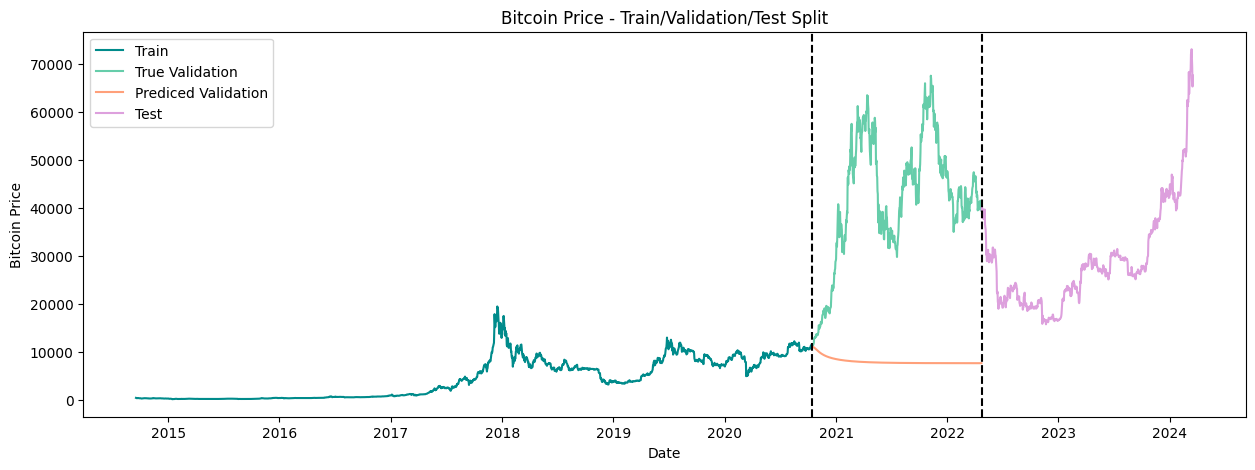

In [ ]:
plt.plot(train_df, color='darkcyan', label='Train')

plt.plot(val_df, color='mediumaquamarine', label='True Validation')

plt.plot(predictions_val_df, color='lightsalmon', label='Prediced Validation')

plt.plot(test_df, color='plum', label='Test')

plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price - Train/Validation/Test Split')
plt.legend()

# Add vertical lines
plt.axvline(x=val_df.index[0], color='black', linestyle='--', label='Train/Validation Split')
plt.axvline(x=test_df.index[0], color='black', linestyle='--', label='Validation/Test Split')

plt.show()

Basically this is the trend we achieved. Of course predicting price just from price but from previous timesteps is practically not possible. We need more features to be able to predict prices correctly.

# Training on Seen Data

## Validation prediction

Just to see if the model follows rolling window properly let's see how it performed on X_val and X_test. Here we should get very good results, but remember we actually input here X_val and X_test, so the data we're trying to predict.

In [ ]:
predictions_val = model.predict(X_val)
predictions_val = scaler.inverse_transform(predictions_val)

predictions_val_df = val_df.copy()
predictions_val_df = predictions_val_df.iloc[30:]
predictions_val_df['Close'] = predictions_val
predictions_val_df.head()

17/17 [==============================] - 0s 10ms/step


,Close
Date,
2020-11-14,15020.417969
2020-11-15,15157.371094
2020-11-16,15252.009766
2020-11-17,15347.913086
2020-11-18,15506.930664


## Testing prediction

In [ ]:
predictions_test = model.predict(X_test)
predictions_test = scaler.inverse_transform(predictions_test)

predictions_test_df = test_df.copy()
predictions_test_df = predictions_test_df.iloc[30:]
predictions_test_df['Close'] = predictions_test
predictions_test_df.head()

21/21 [==============================] - 1s 25ms/step


,Close
Date,
2022-05-24,24290.158203
2022-05-25,24345.281250
2022-05-26,24378.189453
2022-05-27,24373.990234
2022-05-28,24289.984375


## Vizualisation

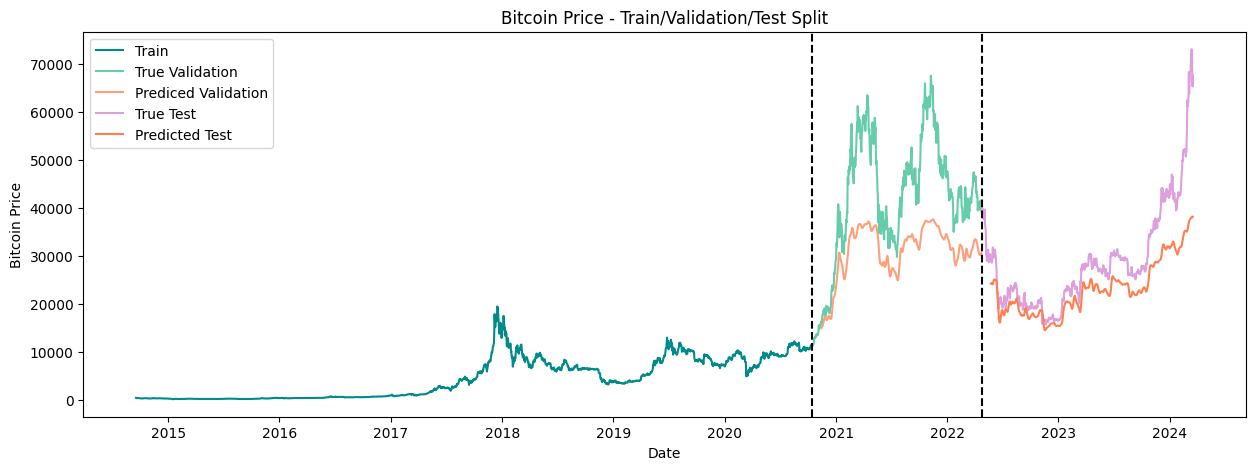

In [ ]:
plt.plot(train_df, color='darkcyan', label='Train')

plt.plot(val_df, color='mediumaquamarine', label='True Validation')

plt.plot(predictions_val_df, color='lightsalmon', label='Prediced Validation')

plt.plot(test_df, color='plum', label='True Test')

plt.plot(predictions_test_df, color='coral', label='Predicted Test')

plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price - Train/Validation/Test Split')
plt.legend()

# Add vertical lines
plt.axvline(x=val_df.index[0], color='black', linestyle='--', label='Train/Validation Split')
plt.axvline(x=test_df.index[0], color='black', linestyle='--', label='Validation/Test Split')

plt.show()

As we see our model performes very well, BUT remember this is not magical LSTM model... We simply inputed as whole X_val and X_train as input, so the data we tried to actually predict. Let's see how model performed on never seen data.

# Future Prediction

## Preprocessing

Here we're be rolling through next 100 days that have never been seen by the model.

In [ ]:
predictions_future_df = prediction(last_30_days = X_test[-1:],
                                    model = model,
                                    scaler=scaler,
                                    first_pred_date = test_df.index[-1] + pd.Timedelta(days=1),
                                    predict_n_days = 100)

## Vizualisation

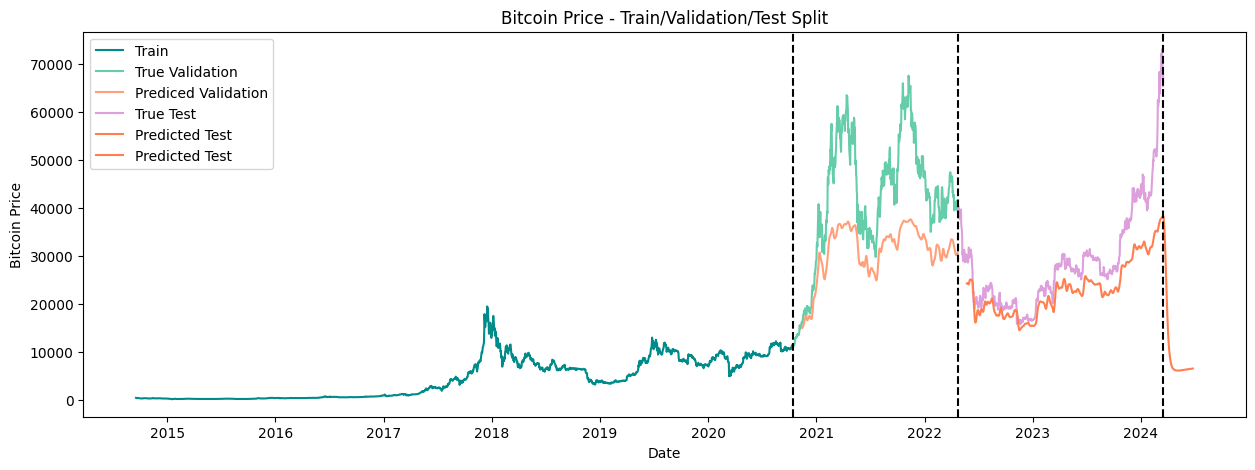

In [ ]:
plt.plot(train_df, color='darkcyan', label='Train')

plt.plot(val_df, color='mediumaquamarine', label='True Validation')

plt.plot(predictions_val_df, color='lightsalmon', label='Prediced Validation')

plt.plot(test_df, color='plum', label='True Test')

plt.plot(predictions_test_df, color='coral', label='Predicted Test')

plt.plot(predictions_future_df, color='coral', label='Predicted Test')

plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price - Train/Validation/Test Split')
plt.legend()

# Add vertical lines
plt.axvline(x=val_df.index[0], color='black', linestyle='--', label='Train/Validation Split')
plt.axvline(x=test_df.index[0], color='black', linestyle='--', label='Validation/Test Split')
plt.axvline(x=df.index[-1], color='black', linestyle='--', label='Test/Future Split')

plt.show()

Close Look

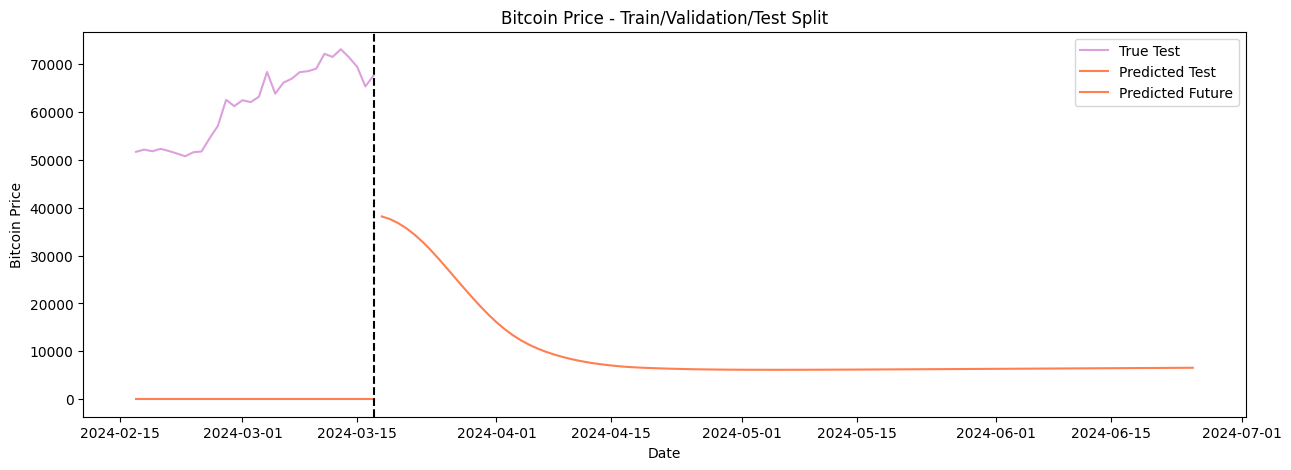

In [ ]:
plt.plot(test_df[-30:], color='plum', label='True Test')

plt.plot(predictions_test_df[-30:], color='coral', label='Predicted Test')

plt.plot(predictions_future_df, color='coral', label='Predicted Future')

plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price - Train/Validation/Test Split')
plt.legend()

# Add vertical lines
plt.axvline(x=df.index[-1], color='black', linestyle='--', label='Test/Future Split')

plt.show()

So here out model performed not that well... probably. Let's see on 2024-07-01.